In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display
import warnings
import json
import requests
import time
import scipy.stats as ss
import statistics
import math
from bioinfokit.analys import norm
from maayanlab_bioinformatics.normalization.quantile import quantile_normalize

# Load data

In [2]:
# Set all variables
meta_class_column_name = 'Sample_characteristics_ch1'
control_name = 'treatment: standard cultivation medium'
treatment = 'treatment: standard cultivation medium + dexamethason'
meta_data_filename = 'GSE186104_series_matrix.txt'
rnaseq_data_filename = 'GSE186104_cross_tabulation_of_gene_expression.txt'
low_expression_threshold = 0.3

# Load in data
try:
    meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0, dtype=str)
except:
    print("Error! Please load a metadata file in txt or tsv format")
try:
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
except:
    print("Error! Please load a RNA-seq expression file in txt or tsv format")
meta_df.index = meta_df.index.map(str)

# Match samples between the metadata and the datasets
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' is not in metadata")
    
meta_df = meta_df[meta_df.index.isin(expr_df.columns)]

# sort metadata by class labels; control first
classes = list(meta_df[meta_class_column_name].unique())
classes.remove(control_name)
classes.insert(0, control_name)
meta_df['tmp_class'] = pd.Categorical(meta_df[meta_class_column_name], classes)
meta_df = meta_df.sort_values('tmp_class')
meta_df = meta_df.drop('tmp_class', axis=1)
expr_df = expr_df.loc[:,meta_df.index]
expr_df = expr_df.groupby(expr_df.index).sum()
try:
    assert(meta_df.shape[0]==expr_df.shape[1])
except:
    print("Error! Input files are in a wrong format.")

dataset = dict()
current_dataset = 'rawdata'
dataset[current_dataset] = expr_df
dataset['dataset_metadata'] = meta_df

## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
current_dataset += '+filter_genes'
dataset[current_dataset] = expr_df

In [5]:
display(meta_df)
display(expr_df)

,Sample_title,Sample_characteristics_ch1
Sample_geo_accession,,
GSM5632354,C1: Untreated control replicate 1,treatment: standard cultivation medium
GSM5632355,C2: Untreated control replicate 2,treatment: standard cultivation medium
GSM5632356,C3: Untreated control replicate 3,treatment: standard cultivation medium
GSM5632357,Dex1: Dexamethason treated sample replicate 1,treatment: standard cultivation medium + dexam...
GSM5632358,Dex2: Dexamethason treated sample replicate 2,treatment: standard cultivation medium + dexam...
GSM5632359,Dex3: Dexamethason treated sample replicate 3,treatment: standard cultivation medium + dexam...


Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,160,60,196,328,274,287
A2m,32,15,19,62,65,36
A3galt2,80,36,75,68,70,47
A4galt,0,0,2,0,1,2
Aaas,541,306,506,295,298,209
...,...,...,...,...,...,...
l7Rn6,392,199,385,174,185,142
mrpl11,374,218,233,144,192,133
mrpl24,611,344,560,222,316,222


# Normalization Methods

In [6]:
# Perform CPM normalization
nm = norm()
nm.cpm(df=expr_df)
dataset['cpm'] = nm.cpm_norm

In [7]:
# Define function for log transformation
def log(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = data.fillna(0)
        data = np.log2(data+1)
        
    return data

In [8]:
dataset['log_transform'] = log(expr_df)

In [9]:
dataset['z_score'] = expr_df.T.apply(ss.zscore, axis=0).T.dropna()

In [10]:
# Define function for quantile normalization
def qnormalization(data):
  
    X_quantile_norm = quantile_normalize(data)
    return X_quantile_norm

In [11]:
dataset['quantile_norm'] = qnormalization(expr_df)

In [12]:
methods = ['rawdata+filter_genes', 'cpm', 'log_transform', 'z_score', 'quantile_norm']

# Differential Gene Expression

In [15]:
# Function for logFC
def logFC(control, treatment, dataset, normalization, meta_class_column_name):
    df = dataset[normalization]
    
    signatures = dict()
    
    signature_label = normalization
    
    cls1_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==control, :].index.tolist() #control
    cls2_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==treatment,:].index.tolist() #case
    
    values = []
    for i in range(len(df)):
        case_mean = statistics.mean(df.iloc[i][cls2_sample_ids])
        control_mean = statistics.mean(df.iloc[i][cls1_sample_ids])
        try:
            values.append(math.log(case_mean/control_mean,2))
        except:
            values.append('NA')

    signature = pd.DataFrame(values, columns = ['logFC'])
    signature.index = df.index
    signature = signature[signature['logFC'] != 'NA']
    signature = signature.sort_values("logFC", ascending=False)
    
    signatures[signature_label] = signature
    
    return signatures

In [16]:
# Get signatures
signatures = {}
for method in methods:
    signature = logFC(control_name, treatment, dataset, method, meta_class_column_name)
    signatures.update(signature)

In [20]:
# Display signatures
for i in range(len(methods)):
    display(signatures[methods[i]])
    print("Table " + str(i + 1) + ": signatures for " + methods[i] + " dataset")

,logFC
gene,
Cd163,8.885696
Orm1,6.087463
Calb2,5.260528
Cd101,4.813069
LOC100909954,4.778442
...,...
Pck1,-5.247928
Asb2,-5.426265
LOC102550863,-5.554589


Table 1: signatures for rawdata+filter_genes dataset


,logFC
gene,
Cd163,9.949058
Orm1,7.079678
Calb2,6.360817
LOC100909954,5.830599
P2rx6,5.745061
...,...
Asb2,-4.653965
RGD1566307,-4.6661
Pck1,-4.703861


Table 2: signatures for cpm dataset


,logFC
gene,
Cd163,4.444776
Orm1,3.764945
Fam46b,3.177024
Mgam,3.166278
Slc30a8,3.145963
...,...
Pck1,-3.43167
Hoxb5,-3.482032
RGD1566307,-3.509989


Table 3: signatures for log_transform dataset


,logFC
gene,
Ces1a,2.0
Mpped1,1.415037
Gabra3,1.0
LOC102556289,1.0
Gpr97,1.0
...,...
LOC102548789,-1.744161
LOC103692198,-2.0
LOC102553689,-2.0


Table 4: signatures for z_score dataset


,logFC
gene,
Cd163,9.866204
Orm1,6.803957
LOC102547513,6.751529
Calb2,6.304671
LOC680590,6.113054
...,...
Siglec15,-5.023289
Olr63,-5.071904
Tmem182,-5.151201


Table 5: signatures for quantile_norm dataset


# Enrichment Analysis

In [21]:
# Get gene lists to put into Enrichr
gene_lists = {}
for method in methods:
    gene_lists["{}: up_200".format(method)] = list(signatures[method].head(200).index)
    gene_lists["{}: down_200".format(method)] = list(signatures[method].tail(200).index)
    gene_lists["{}: both_400".format(method)] = gene_lists["{}: up_200".format(method)] + gene_lists["{}: down_200".format(method)]

In [22]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    library_success = []
    short_id = ''

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        try:
            data = json.loads(response.text)
            results_df  = pd.DataFrame(data[library_name])
            all_ranks.append(list(results_df[0]))
            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            all_adjusted_pvalues.append(list(results_df[6]))
            library_success.append(library_name)
        except:
            print('Error for ' + library_name + ' library')

    return([all_ranks,all_terms,all_pvalues,all_adjusted_pvalues,str(short_id),library_success])

In [23]:
# Get results
results = {}
for gene_list in gene_lists:
    results[gene_list] = Enrichr_API(gene_lists[gene_list], ['ChEA_2016'])

In [24]:
# Extract NR3C1 rankings
# Initialize lists for storing NR3C1 information
names = []
ranks = []
p_val = []
gene_sets = []

# Iterate over each result
for gene_list in gene_lists:
    # Within each gene set, iterate over the transcription factor names
    for i in range(len(results[gene_list][1][0])):
        # If NR3C1 is found, add the information to the lists
        if 'NR3C1' in results[gene_list][1][0][i]:
            names.append(results[gene_list][1][0][i])
            ranks.append(results[gene_list][0][0][i])
            p_val.append(results[gene_list][2][0][i])
            gene_sets.append(gene_list)

In [25]:
df = pd.DataFrame(list(zip(gene_sets, names, ranks, p_val)),
                 columns = ['Gene_Set','Name','Rank','p-value'])
df['Method'] = df.Gene_Set.str.split(":",expand=True)[0]
df

,Gene_Set,Name,Rank,p-value,Method
0,rawdata+filter_genes: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,65,0.703749,rawdata+filter_genes
1,rawdata+filter_genes: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,106,0.884630,rawdata+filter_genes
2,rawdata+filter_genes: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,126,0.901381,rawdata+filter_genes
3,rawdata+filter_genes: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,223,0.972929,rawdata+filter_genes
4,rawdata+filter_genes: both_400,NR3C1 23031785 ChIP-Seq PC12 Mouse,80,0.883008,rawdata+filter_genes
5,rawdata+filter_genes: both_400,NR3C1 21868756 ChIP-Seq MCF10A Human,159,0.982779,rawdata+filter_genes
6,cpm: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,41,0.703749,cpm
7,cpm: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,126,0.939871,cpm
8,cpm: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,65,0.703749,cpm
9,cpm: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,228,0.972929,cpm


# Comparing Rankings

In [26]:
# Calculate and sort by mean rank grouping by method and name
df_averages = df.groupby(['Method', 'Name']).mean().sort_values(by='Rank')
df_averages

Rank  \
Method               Name                                               
cpm                  NR3C1 23031785 ChIP-Seq PC12 Mouse     50.333333   
z_score              NR3C1 23031785 ChIP-Seq PC12 Mouse     70.333333   
rawdata+filter_genes NR3C1 23031785 ChIP-Seq PC12 Mouse     90.333333   
log_transform        NR3C1 23031785 ChIP-Seq PC12 Mouse     93.666667   
quantile_norm        NR3C1 23031785 ChIP-Seq PC12 Mouse    108.000000   
                     NR3C1 21868756 ChIP-Seq MCF10A Human  108.666667   
rawdata+filter_genes NR3C1 21868756 ChIP-Seq MCF10A Human  162.666667   
cpm                  NR3C1 21868756 ChIP-Seq MCF10A Human  175.666667   
log_transform        NR3C1 21868756 ChIP-Seq MCF10A Human  269.666667   
z_score              NR3C1 21868756 ChIP-Seq MCF10A Human  271.000000   

                                                            p-value  
Method               Name                                            
cpm                  NR3C1 23031785 ChIP-Seq PC12 Mouse    0.718870  
z_score              NR3C1 23031785 ChIP-Seq PC12 Mouse    0.959320  
rawdata+filter_genes NR3C1 23031785 ChIP-Seq PC12 Mouse    0.829379  
log_transform        NR3C1 23031785 ChIP-Seq PC12 Mouse    0.966592  
quantile_norm        NR3C1 23031785 ChIP-Seq PC12 Mouse    0.881944  
                     NR3C1 21868756 ChIP-Seq MCF10A Human  0.897021  
rawdata+filter_genes NR3C1 21868756 ChIP-Seq MCF10A Human  0.946779  
cpm                  NR3C1 21868756 ChIP-Seq MCF10A Human  0.967992  
log_transform        NR3C1 21868756 ChIP-Seq MCF10A Human  0.998722  
z_score              NR3C1 21868756 ChIP-Seq MCF10A Human  0.999496

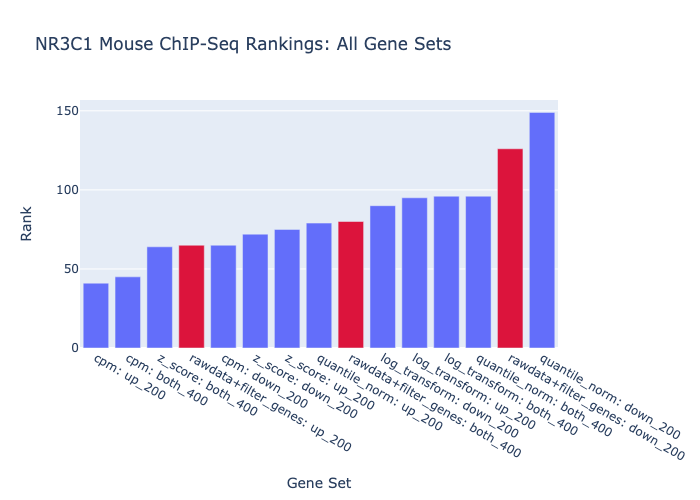

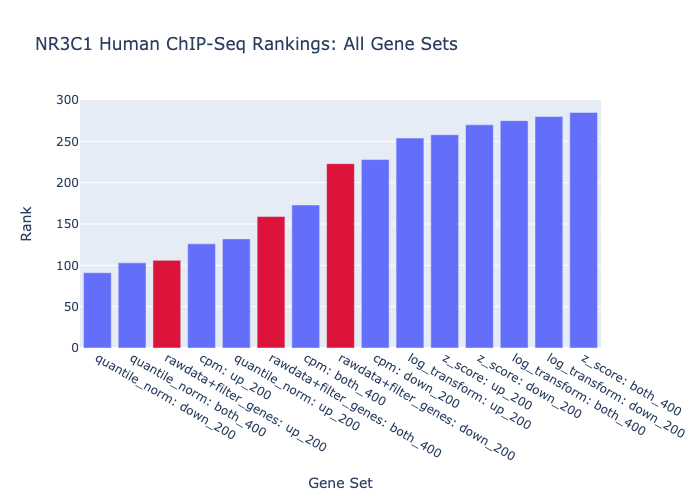

In [27]:
colors = ['#636EFA',] * 15
colors[0] = 'crimson'
colors[1] = 'crimson'
colors[2] = 'crimson'

fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig1.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: All Gene Sets',
                   xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig1.show("png")

fig2=go.Figure()
fig2.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig2.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: All Gene Sets',
                xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig2.show("png")

In [28]:
df_averages = df_averages.reset_index()

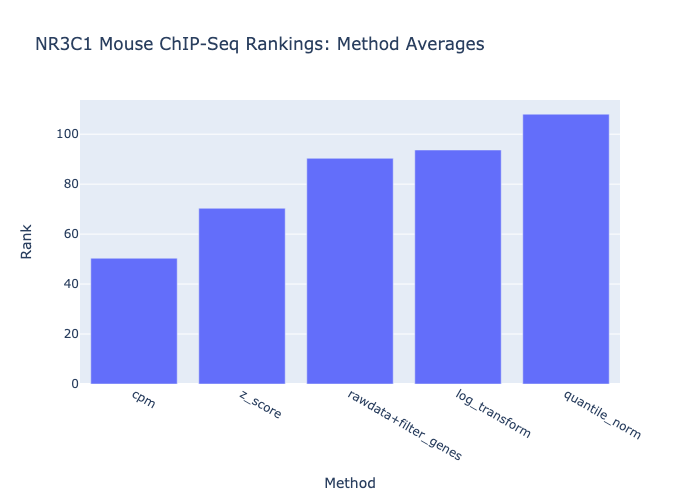

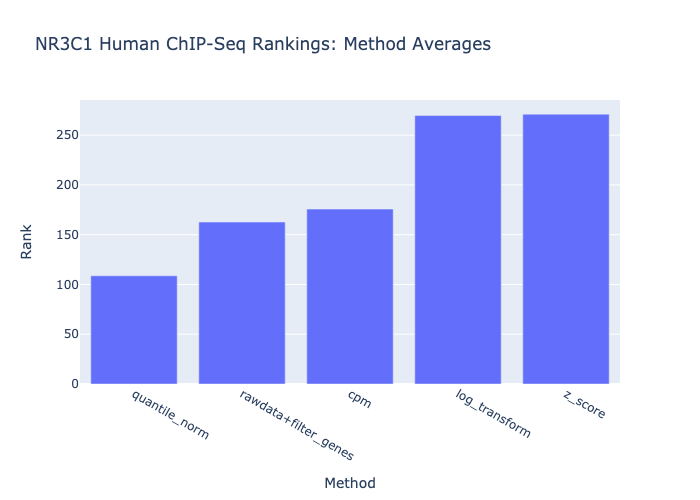

In [30]:
colors = ['#636EFA',] * 5

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig3.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: Method Averages',
                   xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig3.show("png")

fig4=go.Figure()
fig4.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig4.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: Method Averages',
                xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig4.show("png")

In [31]:
# Getting ranks of each method as a list
raw_ranks = df[df["Method"] == 'rawdata+filter_genes']['Rank'].tolist()
significance_threshold = 0.05

for i in range(len(methods) - 1):
    norm_ranks = df[df["Method"] == methods[i + 1]]['Rank'].tolist()
    try:
        w, p = ss.wilcoxon(norm_ranks, raw_ranks)
        print("The p-value for " + methods[i + 1] + " vs. no normalization is " + str(p))
        if p < significance_threshold:
            print(methods[i + 1] + " is statistically significantly different from no normalization")
        else:
            print(methods[i + 1] + " is not statistically significantly different from no normalization")
        print("")
    except:
        print("Wilcoxon test for " + methods[i + 1] + " vs. no normalization can not be done because of a tie.")
        print("")

The p-value for cpm vs. no normalization is 0.4375
cpm is not statistically significantly different from no normalization

The p-value for log_transform vs. no normalization is 0.15625
log_transform is not statistically significantly different from no normalization

The p-value for z_score vs. no normalization is 0.4375
z_score is not statistically significantly different from no normalization

The p-value for quantile_norm vs. no normalization is 0.4375
quantile_norm is not statistically significantly different from no normalization

